In this notebook, there are 2 ways to segment the lung.

Method 1. Simple Image Processing and Morphological operations to segment the lung

Method 2. Pretrained U-net lung segmantation

I tried method 1 and **Marker-Controlled Watershed** method (only showed method 1 in this notebook), but they have the same drawback: choosing 2 largest areas as the lung regions, however in some slices there are more than 2 regions containing lung tissue, and therefore the smaller regions are not selected. e.g. slice017, slice020 and slice 021 segmentation are not good enough. Then I tried Unet with pretrained weights, got the better results.

# **1. Simple Image Processing and Morphological operations to segment the lung**

Some of the code is based from [@kmader](https://www.kaggle.com/kmader/dsb-lung-segmentation-algorithm)'s kernel

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import nibabel as nib
import matplotlib.pyplot as plt
%matplotlib inline
import skimage
from skimage.morphology import disk, dilation, binary_erosion, remove_small_objects, erosion, closing, reconstruction, binary_closing
from skimage.measure import label,regionprops, perimeter
from skimage.morphology import binary_dilation, binary_opening
from skimage.filters import roberts, sobel
from skimage import measure, feature
from skimage.segmentation import clear_border, mark_boundaries
from skimage import data
from scipy import ndimage as ndi
import cv2

Resize all the images into the same size. Directly cropping the image loses some lung pixels, so here I chose to use padding the images.

In [2]:
#resize images
def resize_img(img):
    h, w = img.shape[0], img.shape[1]
    min_side=512
    #resize min_side 
    scale = max(w, h) / float(min_side)
    new_w, new_h = int(w/scale), int(h/scale)
    resize_img = cv2.resize(img, (new_w, new_h))
    # padding min_side * min_side
    x = (min_side-new_h) // 2
    y = (min_side-new_w) // 2
    if (min_side-new_h)%2!=0:
        pad_img = cv2.copyMakeBorder(resize_img, x+1, x, y, y, cv2.BORDER_CONSTANT, value=[0,0,0])
    elif (min_side-new_w)%2!=0:
        pad_img = cv2.copyMakeBorder(resize_img, x, x, y+1, y, cv2.BORDER_CONSTANT, value=[0,0,0])
    else:
        pad_img = cv2.copyMakeBorder(resize_img, x, x, y, y, cv2.BORDER_CONSTANT, value=[0,0,0])
    return pad_img

<Figure size 2304x2304 with 0 Axes>

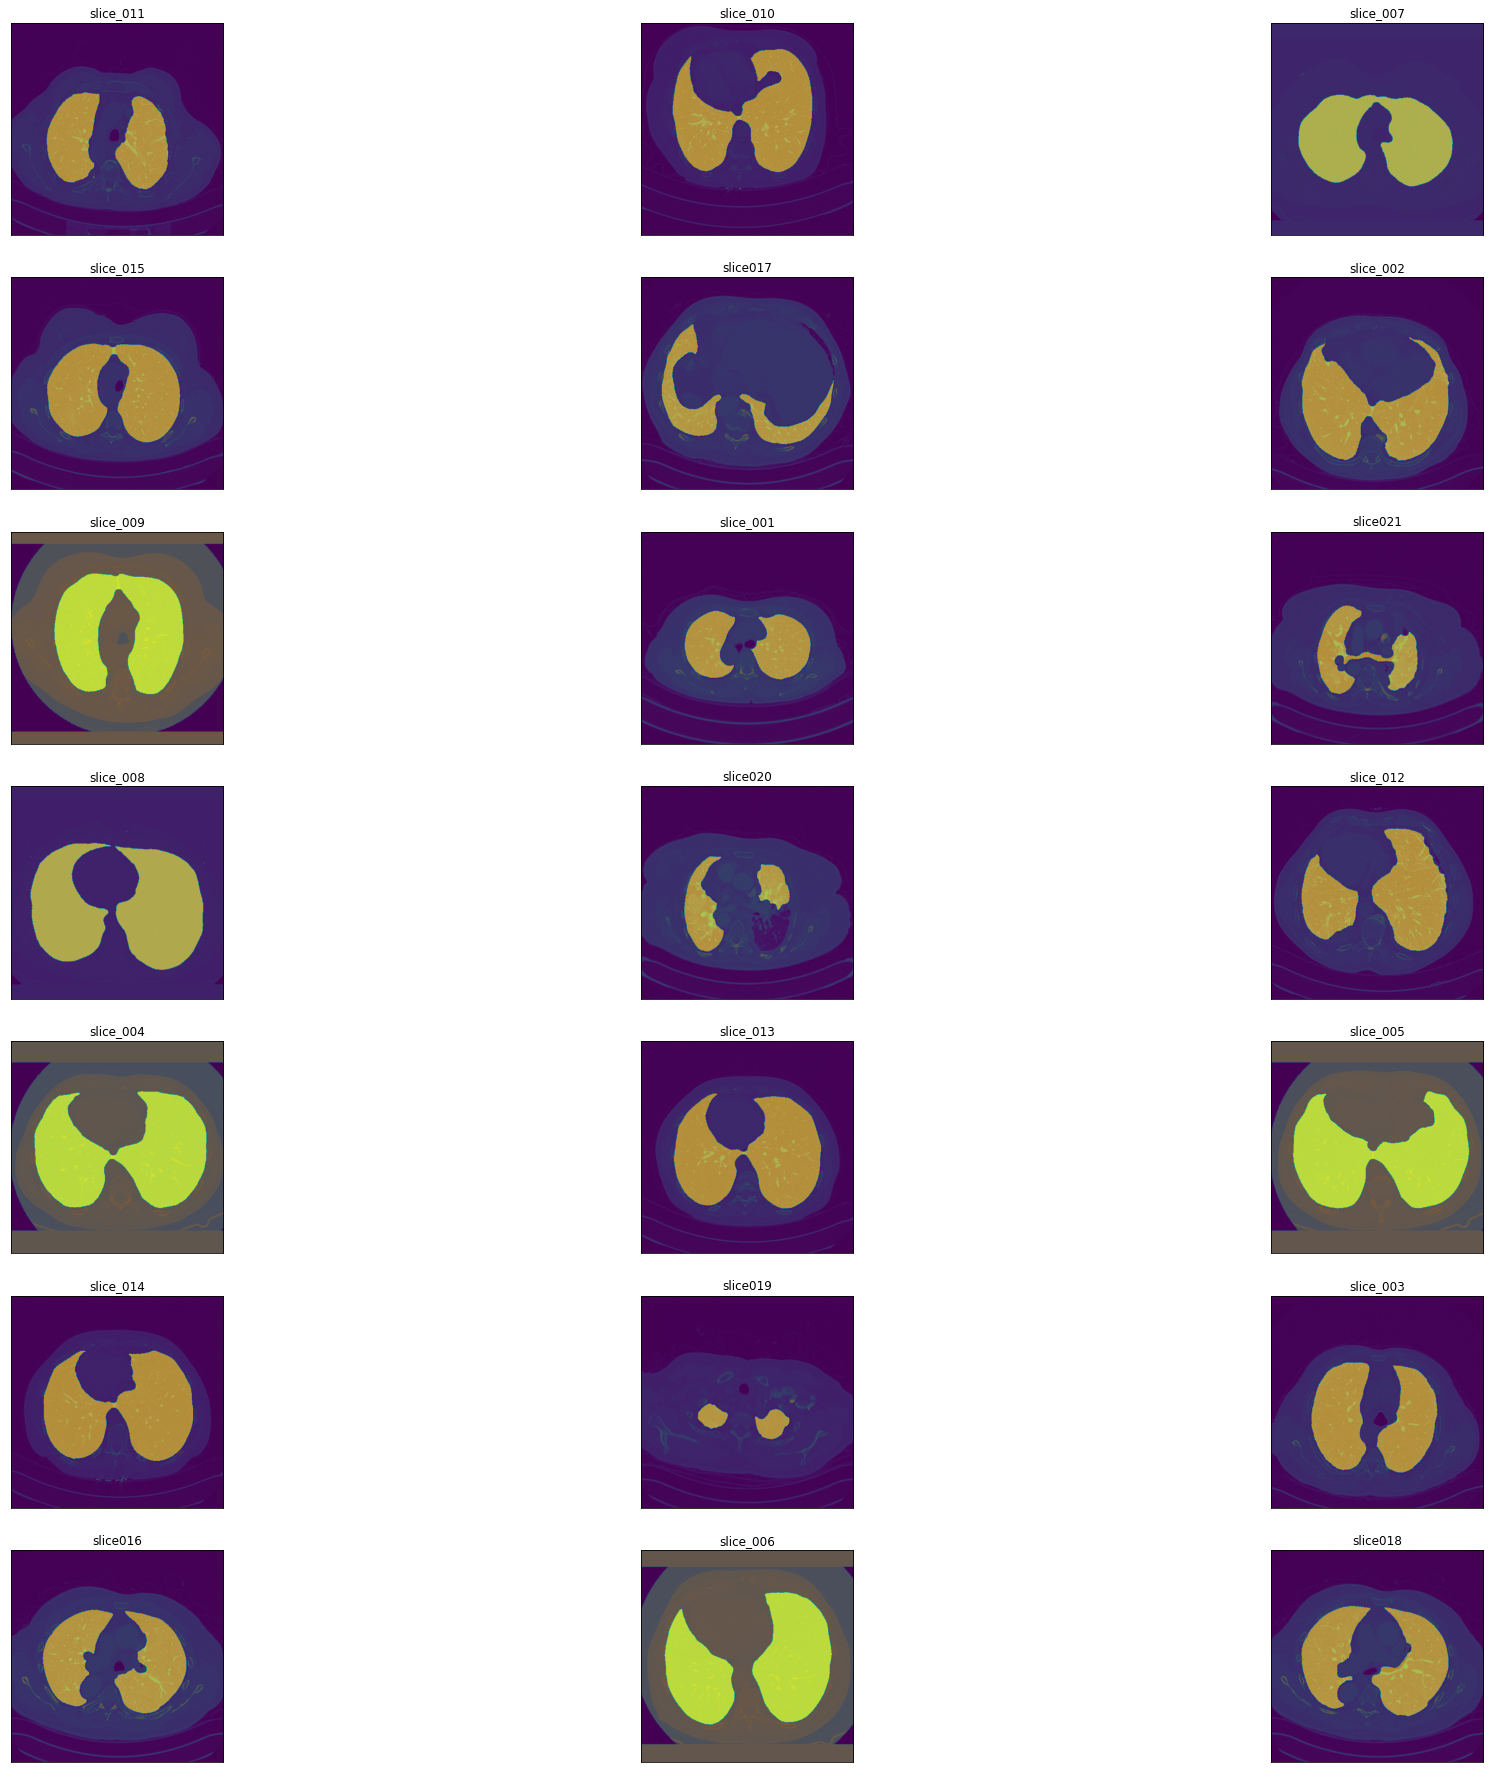

In [3]:
def get_segmented_lungs(raw_im, plot=False):
    im=raw_im.copy()
    '''
    Step 1: Convert into a binary image. 
    '''
    binary = im < -400
    '''
    Step 2: Remove the blobs connected to the border of the image.
    '''
    cleared = clear_border(binary)
    '''
    Step 3: Label the image.
    '''
    label_image = label(cleared)
    '''
    Step 4: Keep the labels with 2 largest areas.
    '''
    areas = [r.area for r in regionprops(label_image)]
    areas.sort()
    if len(areas) > 2:
        for region in regionprops(label_image):
            if region.area < areas[-2]:
                for coordinates in region.coords:                
                       label_image[coordinates[0], coordinates[1]] = 0
    binary = label_image > 0
    '''
    Step 5: Erosion operation with a disk of radius 2. 
    This operation is seperate the lung nodules attached to the blood vessels.
    '''
    binary = binary_erosion(binary, disk(2))
    '''
    Step 6: Closure operation with a disk of radius 10. 
    This operation is to keep nodules attached to the lung wall.
    '''
    binary = binary_closing(binary, disk(10))
    '''
    Step 7: Fill in the small holes inside the binary mask of lungs.
    '''
    edges = roberts(binary)
    binary = ndi.binary_fill_holes(edges)
    '''
    Step 8: Superimpose the binary mask on the input image.
    '''
    get_high_vals = binary == 0
    im[get_high_vals] = 0 
    return binary

for dirname, _, filenames in os.walk('../input/lung21'):
    plt.figure(figsize=(32,32))
    for idx, filename in enumerate(filenames):
        plt.subplot(7,3,idx+1)
        image_path=os.path.join(dirname, filename)
        image = nib.load(image_path)
        image=image.get_fdata()
        image=np.rot90(image, k=-1, axes=(0,1))       
        if image.shape[0] != 512 or image.shape[1] != 512:
            image=resize_img(image)
        mask=get_segmented_lungs(image,True)
        plt.imshow(image)
        plt.imshow(mask, alpha=0.6)
        plt.xticks([])
        plt.yticks([])
        plt.title(filename.split('.')[0])
    plt.show()

From the graph, we can clear see slice017 and slice020 missing one part of the lung, slice 021 includes the main bronchi

# 2. Pretrained U-net lung segmantation

Pretrained weights and some code are from [@hfutybx](https://www.kaggle.com/hfutybx/unet-densenet121-lung-of-segmentation)

In [4]:
import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np
import random
import os
import glob
import pandas as pd 
from tqdm import tqdm
import sys
import glob
import cv2

from sklearn.utils import shuffle

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
from torch.optim.lr_scheduler import  ReduceLROnPlateau

Add model

In [5]:
sys.path.append('../input/efficientnet-pytorch/EfficientNet-PyTorch-master')
sys.path.append('../input/pretrainedmodels/pretrainedmodels-0.7.4/')
sys.path.append('../input/segmentation-models-pytorch/')
import segmentation_models_pytorch as smp

batch = 8
output_path = './'
device =  torch.device('cuda:0')
experiment_name = 'lung_Unet_densenet121'

model = smp.Unet('densenet121', classes=1, in_channels=1,activation='sigmoid',encoder_weights='imagenet').to(device)

Downloading: "http://data.lip6.fr/cadene/pretrainedmodels/densenet121-fbdb23505.pth" to /root/.cache/torch/checkpoints/densenet121-fbdb23505.pth


In [6]:
class Test_Generate(Dataset):
    def __init__(self,img_paths):
        self.img_paths = img_paths
        
    def __getitem__(self,index):
        img = nib.load(self.img_paths[index])
        slice_img=img.get_fdata()
        slice_img=np.rot90(slice_img, k=-1, axes=(0,1))
        if slice_img.shape[0] != 512 or slice_img.shape[1] != 512:
            slice_img=resize_img(slice_img)
        MIN_BOUND = -1000.0
        MAX_BOUND = 400.0
        slice_img = (slice_img - MIN_BOUND) / (MAX_BOUND - MIN_BOUND)
        slice_img[slice_img > 1] = 1.
        slice_img[slice_img < 0] = 0.
        
        slice_img = (slice_img*255).astype(np.uint8)   
        slice_img = slice_img[None,:,:]
        slice_img = (slice_img/255).astype(np.float32)
        return slice_img
        
    def __len__(self):
        return len(self.img_paths)

In [7]:
root_path = '../input/lung21/*/*'
img_paths = sorted(glob.glob(root_path))
test_db= Test_Generate(img_paths)
test_loader = DataLoader(test_db, batch_size=3, shuffle=False, num_workers=0)

model.load_state_dict(torch.load('../input/2020osic/best_lung_Unet_densenet121_my.pth'))
model.eval()

outs = []
for idx, sample in enumerate(test_loader):
    print(idx)
    image = sample
    image = image.to(device)
    with torch.no_grad():
        out = model(image)
    out = out.cpu().data.numpy()
    out = np.where(out>0.5,1,0)
    out = np.squeeze(out)
    print(out.shape)
    outs.append(out)
outs = np.concatenate(outs)

0
(3, 512, 512)
1
(3, 512, 512)
2
(3, 512, 512)
3
(3, 512, 512)
4
(3, 512, 512)
5
(3, 512, 512)
6
(3, 512, 512)


**Display the masks**

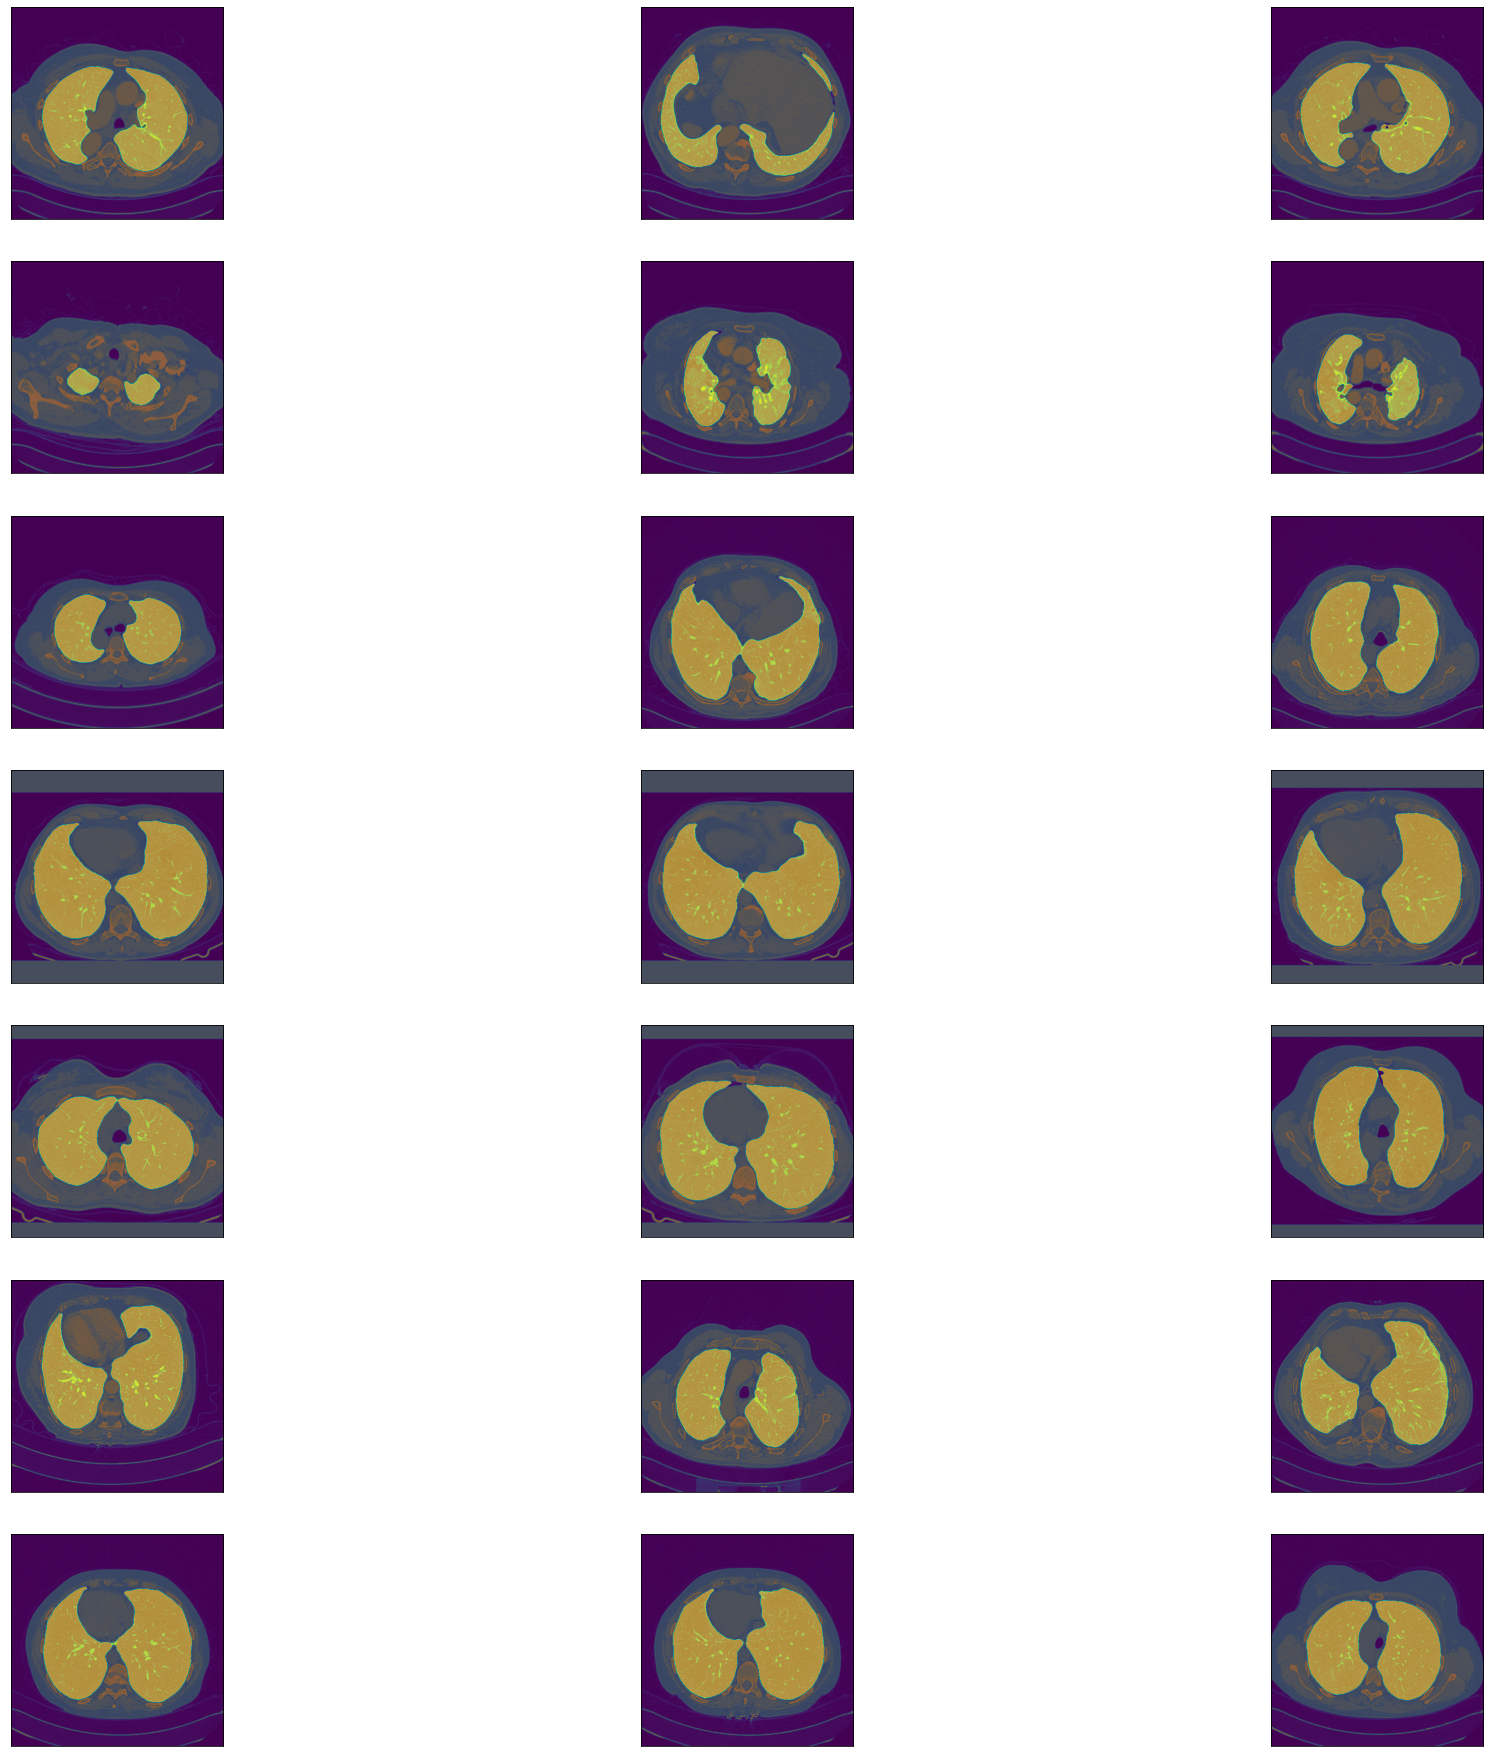

In [8]:
plt.figure(figsize=(32,32))
for idx in range(len(outs)):
    outs[idx]=remove_small_objects(outs[idx]>0 ,min_size=1000,connectivity=1) 
    plt.subplot(7,3,idx+1)
    plt.imshow(test_db[idx][0])
    plt.imshow(outs[idx], alpha=0.6)
    plt.xticks([])
    plt.yticks([])
plt.show()

**Save masks**

In [9]:
root_path = '../input/lung21/*/*'
img_paths = sorted(glob.glob(root_path))
test_db= Test_Generate(img_paths)
test_loader = DataLoader(test_db, batch_size=1, shuffle=False, num_workers=0)

model.load_state_dict(torch.load('../input/2020osic/best_lung_Unet_densenet121_my.pth'))
model.eval()

for idx, sample in enumerate(test_loader):
    image = sample
    image = image.to(device)
    with torch.no_grad():
        out = model(image)
    out = out.cpu().data.numpy()
    out = np.where(out>0.5,1,0)
    out = np.squeeze(out)
    func = nib.load(img_paths[idx])
    out=remove_small_objects(out>0 ,min_size=1000,connectivity=1).astype(int)  
    name = (img_paths[idx].split('/')[-1]).split('.')[0] + '_mask.nii.gz'
    ni_img = nib.Nifti1Image(out, func.affine)
    nib.save(ni_img,os.path.join('./',name)) 